In [12]:
! pip install -U /Users/kef74yk/Dropbox_w/repos/averagers    

import datetime
import importlib
import itertools

import numpy
import pandas
import ephem
import scipy.stats
import matplotlib
import seaborn
import averagers
importlib.reload(averagers)

font_size = 8

Processing ./Dropbox_w/repos/averagers


 \

 done
  Stored in directory: /private/var/folders/v9/yv26rx6x68z_8l097tyk07_40000gq/T/pip-ephem-wheel-cache-_0lx5dli/wheels/46/05/09/404815b893a0bfefba47566bb0e61fd6f64294c7820d1eca33
Successfully built averagers


  Found existing installation: averagers 0.1.0
    Uninstalling averagers-0.1.0:
      Successfully uninstalled averagers-0.1.0


In [2]:
wd = "/Users/kef74yk/Dropbox_p/data/Cephalotus follicularis/Heterophylly assay/HeterophyllyAssayReanalyses_20190418/"
infile = '20190930_HeterophyllyAssaySummary.tsv'
every_minute_file = '/Users/kef74yk/Dropbox_p/data/Cephalotus follicularis/Climate/Fukushima_20171120_Albany/HD01D_Data_009999_45926019484443.txt'
habitat_dir = '/Users/kef74yk/Dropbox_p/data/Cephalotus follicularis/Habitat/'

In [3]:
def calc_cor(df,col1,col2):
    tmp = df.loc[:,[col1,col2]].dropna()
    return numpy.corrcoef(tmp[col1],tmp[col2])[1][0]

In [4]:
CtoK = False
em = pandas.read_csv(every_minute_file)
em = em.iloc[:,[2,3,4,5,6,7]]
em.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature']
em.loc[:,'Temperature'] = pandas.to_numeric(em['Temperature'], errors='coarse')
if CtoK:
    em.loc[:,'Temperature'] = em.loc[:,'Temperature'] + 273.15
em = em.sort_values(by=['Year','Month','Day','Hour','Minute'])

location_name = 'Albany Airport'
lon = 117.8158
lat = -34.9411
timezone = 8
start_date = datetime.datetime(2012, 1, 1, 0) # yyyy,m,d,h 
end_date = datetime.datetime(2016, 12, 31, 0)
emd = averagers.get_photoperiod(start_date, end_date, lat=lat, lon=lon, timezone=timezone)

for col in ['Ave','Min','Max','Min_next','Max_prev','Num_point','Num_missing']:
    if col=='Ave':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].mean())
        tmp = tmp.reset_index()
    elif col=='Min':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].min())
        tmp = tmp.reset_index()
    elif col=='Max':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].max())
        tmp = tmp.reset_index()
    elif col=='Min_next':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].min())
        tmp = tmp.reset_index()
        tmp.loc[0:(tmp.shape[0]-2),'Temperature'] = tmp.loc[1:(tmp.shape[0]),'Temperature'].tolist()
        tmp.loc[tmp.shape[0],'Temperature'] = numpy.nan
    elif col=='Max_prev':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].max())
        tmp = tmp.reset_index()
        tmp.loc[1:tmp.shape[0],'Temperature'] = tmp.loc[0:(tmp.shape[0]-2),'Temperature'].tolist()
        tmp.loc[0,'Temperature'] = numpy.nan
    elif col=='Num_point':
        tmp = pandas.DataFrame(em.groupby(by=['Year','Month','Day'])['Temperature'].count())
        tmp = tmp.reset_index()
    elif col=='Num_missing':
        tmp = em.copy()
        tmp.loc[:,'Temperature'] = tmp['Temperature'].isnull()
        tmp = pandas.DataFrame(tmp.groupby(by=['Year','Month','Day'])['Temperature'].sum())
        tmp = tmp.reset_index()
    tmp.columns = ['Year','Month','Day',col]
    emd = pandas.merge(emd, tmp, how='left')

emd['Ave_avg'] = (emd['Min']+emd['Max'])/2
del em,tmp
print('Number of days: {0}'.format(emd.shape[0]))
print('Number of days with average temperature: {0}'.format((~emd['Ave'].isnull()).sum()))
print('Number of days with complete statistics: {0}'.format(emd.dropna().shape[0]))
print('Number of days with >60 missing points: {0}'.format((emd['Num_missing']>60).sum()))
print('Number of days with >120 missing points: {0}'.format((emd['Num_missing']>120).sum()))
print('Number of days with >240 missing points: {0}'.format((emd['Num_missing']>240).sum()))
print('Pearson rho between average temperature and daytime: {}'.format(calc_cor(emd,'Ave','Daytime')))

loc2, scale2 = scipy.stats.norm.fit(emd['Ave'].dropna())
print('Fitted average temperature to a gaussian distribution: location={}, scale={}'.format(loc2,scale2))
a1, b1, loc1, scale1 = scipy.stats.beta.fit(emd['Daytime'])
print('Fitted daytime to a beta distribution: a={}, b={}, location={}, scale={}'.format(a1,b1,loc1,scale1))

Number of days: 1827
Number of days with average temperature: 1815
Number of days with complete statistics: 1814
Number of days with >60 missing points: 38
Number of days with >120 missing points: 31
Number of days with >240 missing points: 14
Pearson rho between average temperature and daytime: 0.6121474935896348
Fitted average temperature to a gaussian distribution: location=15.205151936229269, scale=3.510960390478256
Fitted daytime to a beta distribution: a=0.5830195603048154, b=0.5902465068550999, location=9.813888888888886, scale=4.707777777777781


In [6]:
methods = ['DH2006','KF']
window_sizes = [0,1,2,3]

yparams = dict()
mparams = dict()
for method in methods:
    yparams[method] = averagers.get_params(emd, method=method)
    col = 'Ave_simY_'+method
    emd[col] = averagers.get_average_temperature(emd, yparams[method], method=method)
    print('method = {}, Year, rho = {}'.format(method, calc_cor(emd,'Ave',col)))
    mparams[method] = dict()
    for ws in window_sizes:
        col = 'Ave_simM_'+method+'_ws'+str(ws)
        mparams[method][str(ws)] = averagers.get_month_params(emd, window_size=ws, method=method)
        emd[col] = averagers.get_month_average_temperature(emd, mparams[method][str(ws)], method=method)
        print('method = {}, Month window = {}, rho = {}'.format(method, ws, calc_cor(emd,'Ave',col)))
emd.tail()

method = DH2006, Year, rho = 0.9812211293359545


method = DH2006, Month window = 0, rho = 0.9820334727510678


method = DH2006, Month window = 1, rho = 0.9819219935251348


method = DH2006, Month window = 2, rho = 0.9818830185018275


method = DH2006, Month window = 3, rho = 0.9818965490796764


method = KF, Year, rho = 0.9837206437320275


method = KF, Month window = 0, rho = 0.9833992423158734


method = KF, Month window = 1, rho = 0.9834544207651028


method = KF, Month window = 2, rho = 0.9835040598202777


method = KF, Month window = 3, rho = 0.9835872694449569


,Daytime,Year,Month,Day,Sunrise,Sunset,Sunrise_nondimensional,Sunset_nondimensional,Ave,Min,...,Ave_simM,Ave_simM_DH2006_ws0,Ave_simM_DH2006_ws1,Ave_simM_DH2006_ws2,Ave_simM_DH2006_ws3,Ave_simY_KF,Ave_simM_KF_ws0,Ave_simM_KF_ws1,Ave_simM_KF_ws2,Ave_simM_KF_ws3
1822,14.506389,2016,12,27,2016-12-27 05:54:36.000000,2016-12-27 20:24:59.000001,5.910000,20.416389,14.345556,10.8,...,15.787936,14.900336,14.827902,14.856280,14.864347,15.848469,15.623474,15.605618,15.735646,15.787936
1823,14.500556,2016,12,28,2016-12-28 05:55:15.000001,2016-12-28 20:25:17.000002,5.920833,20.421389,15.231181,13.2,...,15.941280,15.890417,15.842715,15.861122,15.866178,15.927733,15.897562,15.881148,15.917100,15.941280
1824,14.493889,2016,12,29,2016-12-29 05:55:56.000002,2016-12-29 20:25:34.000003,5.932222,20.426111,16.417639,14.7,...,16.899273,16.741287,16.695104,16.694503,16.682599,16.861516,16.873765,16.852437,16.874810,16.899273
1825,14.486389,2016,12,30,2016-12-30 05:56:38.000003,2016-12-30 20:25:49.000004,5.943889,20.430278,15.119097,10.9,...,14.511746,14.247120,14.183747,14.200862,14.200886,14.499482,14.441635,14.419037,14.476250,14.511746
1826,14.477778,2016,12,31,2016-12-31 05:57:22.000004,2016-12-31 20:26:02.000005,5.956111,20.433889,15.804583,10.8,...,14.885567,14.683941,14.601714,14.608936,14.595302,14.826856,14.835941,14.800251,14.843089,14.885567


In [8]:
years = emd.Year.unique()
print('Cross validation years:', years)
tests = dict()
cv_yparams = dict()
cv_mparams = dict()
for year in years:
    test_data = emd.loc[(emd.Year==year),:]
    learn_data = emd.loc[(emd.Year!=year),:]
    cv_yparams[str(year)] = dict()
    cv_mparams[str(year)] = dict()
    for method in methods:
        print('method = {0}, Year, year = {1}'.format(method, year))
        cv_yparams[str(year)][method] = averagers.get_params(learn_data, method=method)
        test_data.loc[:,'Ave_simY_'+method] = averagers.get_average_temperature(test_data, cv_yparams[str(year)][method], method=method)
        tests[str(year)] = test_data
        cv_mparams[str(year)][method] = dict()
        for ws in window_sizes:
            print('method = {0}, Month window = {1}, year = {2}'.format(method, ws, year))
            cv_mparams[str(year)][method][str(ws)] = averagers.get_month_params(learn_data, window_size=ws, method=method)
            test_data.loc[:,'Ave_simM_'+method+'_ws'+str(ws)] = averagers.get_month_average_temperature(test_data, cv_mparams[str(year)][method][str(ws)], method=method)
    tests[str(year)] = test_data

Cross validation years: [2012 2013 2014 2015 2016]
method = DH2006, Year, year = 2012


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


method = DH2006, Month window = 0, year = 2012


method = DH2006, Month window = 1, year = 2012


method = DH2006, Month window = 2, year = 2012


method = DH2006, Month window = 3, year = 2012


method = KF, Year, year = 2012


method = KF, Month window = 0, year = 2012


method = KF, Month window = 1, year = 2012


method = KF, Month window = 2, year = 2012


method = KF, Month window = 3, year = 2012


method = DH2006, Year, year = 2013


method = DH2006, Month window = 0, year = 2013


method = DH2006, Month window = 1, year = 2013


method = DH2006, Month window = 2, year = 2013


method = DH2006, Month window = 3, year = 2013


method = KF, Year, year = 2013


method = KF, Month window = 0, year = 2013


method = KF, Month window = 1, year = 2013


method = KF, Month window = 2, year = 2013


method = KF, Month window = 3, year = 2013


method = DH2006, Year, year = 2014


method = DH2006, Month window = 0, year = 2014


method = DH2006, Month window = 1, year = 2014


method = DH2006, Month window = 2, year = 2014


method = DH2006, Month window = 3, year = 2014


method = KF, Year, year = 2014


method = KF, Month window = 0, year = 2014


method = KF, Month window = 1, year = 2014


method = KF, Month window = 2, year = 2014


method = KF, Month window = 3, year = 2014


method = DH2006, Year, year = 2015


method = DH2006, Month window = 0, year = 2015


method = DH2006, Month window = 1, year = 2015


method = DH2006, Month window = 2, year = 2015


method = DH2006, Month window = 3, year = 2015


method = KF, Year, year = 2015


method = KF, Month window = 0, year = 2015


method = KF, Month window = 1, year = 2015


method = KF, Month window = 2, year = 2015


method = KF, Month window = 3, year = 2015


method = DH2006, Year, year = 2016


method = DH2006, Month window = 0, year = 2016


method = DH2006, Month window = 1, year = 2016


method = DH2006, Month window = 2, year = 2016


method = DH2006, Month window = 3, year = 2016


method = KF, Year, year = 2016


method = KF, Month window = 0, year = 2016


method = KF, Month window = 1, year = 2016


method = KF, Month window = 2, year = 2016


method = KF, Month window = 3, year = 2016


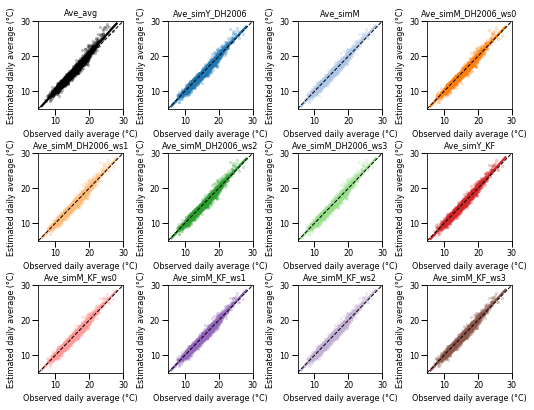

In [14]:
stats = emd.columns[emd.columns.str.startswith('Ave_')]
labels = stats
#labels = ['Tavg','TsimY','TsimM0','TsimM1','TsimM2','TsimM3',]
fig,axes = matplotlib.pyplot.subplots(nrows=3, ncols=4, figsize=(7.2,5.5))
axes = axes.flat

xymin = 5
xymax = 30
alpha = 0.2
myplt = ['black',] + seaborn.color_palette('tab20')
years = [2012,2013,2014,2015,2016]
for i,stat in enumerate(stats):
    ax = axes[i]
    seaborn.regplot('Ave', stat, data=emd, fit_reg=True, ax=ax, truncate=False,
                    color=myplt[i], scatter_kws={'alpha':alpha,'s':5},)
    ax.plot([xymin,xymax], [xymin,xymax], lw=1, linestyle='--', color='black')
    ax.set_xlim(xymin,xymax)
    ax.set_ylim(xymin,xymax)
    ax.set_xlabel('Observed daily average (°C)', fontsize=font_size)
    ax.set_ylabel('Estimated daily average (°C)', fontsize=font_size)
    ax.set_title(labels[i], fontsize=font_size)
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2,
                   top=False, right=False, labelsize=font_size)
    ax.set_xticks([10,20,30])
    ax.set_yticks([10,20,30])

fig.tight_layout(pad=0, w_pad=0, h_pad=0)
outbase = 'CV_scatter'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

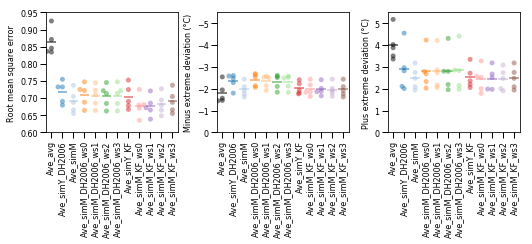

In [15]:
fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,3.2))
axes = axes.flat

alpha = 0.5

err_labels = ['Root mean square error','Minus extreme deviation (°C)','Plus extreme deviation (°C)']
ylims = [[0.6,0.95], [0,-5.5], [0,5.5]]
for i,err in enumerate(['RMSE','extreme_minus','extreme_plus']):
    ax = axes[i]
    df_tmp = pandas.DataFrame()
    for year in years:
        test_data = tests[str(year)].dropna()
        tmp = {'Year':[year,]}
        for stat in stats:
            value = numpy.nan
            if err=='RMSE':
                value = (((test_data[stat]-test_data['Ave'])**2).sum()/test_data.shape[0])**0.5
            elif err=='extreme_minus':
                value = (test_data[stat]-test_data['Ave']).min()
            elif err=='extreme_plus':
                value = (test_data[stat]-test_data['Ave']).max()
            tmp[stat] = [value,]
        tmp = pandas.DataFrame(tmp)
        df_tmp = pandas.concat([df_tmp,tmp], ignore_index=True, sort=False)
    dfplot = df_tmp.drop('Year',axis=1)
    dfplot = pandas.DataFrame(dfplot.stack())
    dfplot = dfplot.reset_index()
    dfplot = dfplot.drop('level_0',axis=1)
    dfplot.columns = ['stat','value']
    seaborn.swarmplot('stat','value',data=dfplot, ax=ax, palette=myplt, alpha=alpha)
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_ylabel(err_labels[i], fontsize=font_size)
    ax.set_ylim(ylims[i][0], ylims[i][1])
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2,
                   top=False, right=False, labelsize=font_size)
    ax.tick_params(axis='x', rotation=90)
    mean_width = 0.7
    dfmean = dfplot.groupby('stat').mean()
    j = 0
    for tick,xlab in zip(ax.get_xticks(),ax.get_xticklabels()):
        mean_val = dfmean.loc[xlab.get_text(),'value']
        ax.plot([tick-mean_width/2,tick+mean_width/2],[mean_val,mean_val],lw=2, color=myplt[j], alpha=alpha)
        j += 1

fig.tight_layout(pad=0, w_pad=0, h_pad=0)
outbase = 'CV_error'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.4845859688128153e-07, top=3.4845859688128153e-07
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.4845859688128153e-07, top=3.4845859688128153e-07
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.4845859688128153e-07, top=3.4845859688128153e-07
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=3.4845859688128153e-07, top=3.4845859688128

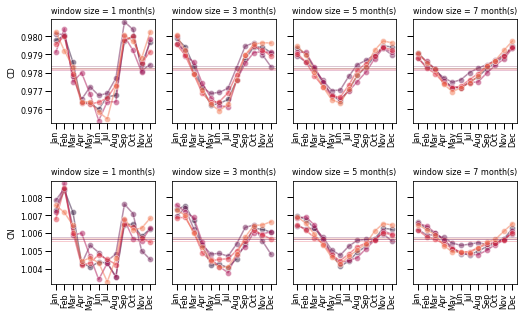

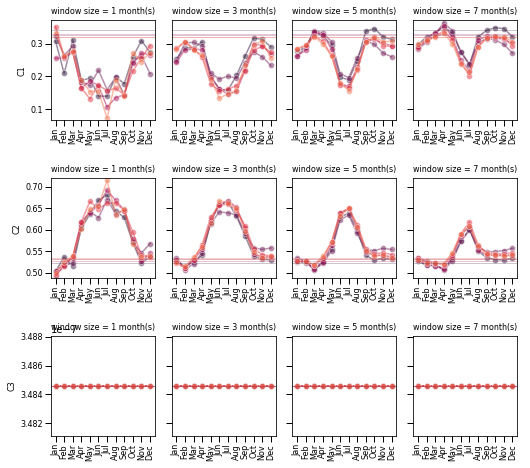

In [16]:
myplt = seaborn.color_palette('rocket')[0:len(years)]
methods = ['DH2006','KF']
alpha=0.5

for method in methods:
    coefs = list(cv_yparams[list(cv_yparams.keys())[0]][method].keys())
    coefs = [ coef for coef in coefs if coef!='variance' ]
    fig,axes = matplotlib.pyplot.subplots(nrows=len(coefs), ncols=len(window_sizes), figsize=(7.2,len(coefs)*2.1), sharey=False)
    axes = axes.flat
    df_yparam = pandas.DataFrame()
    for i,coef in enumerate(coefs):
        for j,year in enumerate(years):
            tmp = pandas.DataFrame({'Value':[cv_yparams[str(year)][method][coef],],'Year':[year,],'Coef':[coef,]})
            df_yparam = pandas.concat([df_yparam, tmp], ignore_index=True)

    df_mparam = pandas.DataFrame()
    for i,coef in enumerate(coefs):
        for ws in window_sizes:
            for j,year in enumerate(years):
                x = numpy.arange(1,13,1)
                y = list()
                for w in x:
                    y.append(cv_mparams[str(year)][method][str(ws)][str(w)][coef])
                tmp = pandas.DataFrame({'Month':x,'Value':y})
                tmp['Year'] = year
                tmp['Coef'] = coef
                tmp['Window_size'] = ws
                df_mparam = pandas.concat([df_mparam, tmp], ignore_index=True)

    i = 0
    current_coef = 'placeholder'
    for coef in coefs:
        ymin = min(df_mparam.loc[(df_mparam['Coef']==coef),'Value'].min(), df_yparam.loc[(df_yparam['Coef']==coef),'Value'].min())
        ymax = max(df_mparam.loc[(df_mparam['Coef']==coef),'Value'].max(), df_yparam.loc[(df_yparam['Coef']==coef),'Value'].max())
        ymar_unit = (ymax-ymin)*0.025
        ymin -= ymar_unit
        ymax += ymar_unit
        for ws in window_sizes:
            ax = axes[i]
            m = df_mparam.loc[(df_mparam['Coef']==coef)&(df_mparam['Window_size']==ws),:]
            y = df_yparam.loc[(df_yparam['Coef']==coef),:]
            seaborn.lineplot('Month', 'Value', hue='Year', data=m, color='black', alpha=alpha, ax=ax,
                             palette=myplt, marker='o', legend=False)
            mavg = m.loc[:,['Month','Value']].groupby('Month').mean()
            for j,val in enumerate(y['Value']):
                ax.axhline(val, color=myplt[j], lw=0.5, alpha=alpha)
            ax.set_ylim(ymin,ymax)
            ax.set_xlabel('', fontsize=font_size)
            ax.set_title('window size = '+str(ws*2+1)+' month(s)', fontsize=font_size)
            ax.set_xticks(numpy.arange(1,13,1))
            month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
            ax.set_xticklabels(month_labels, rotation=90, fontsize=font_size)
            if current_coef==coef:
                yticklabels = ['',] * len(ax.get_yticklabels())
                ax.set_yticklabels(yticklabels, fontsize=font_size)
                ylabel = ''
            else:
                ylabel = coef
            ax.set_ylabel(ylabel, fontsize=font_size)
            ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False, labelsize=font_size)
            i += 1
            current_coef = coef

    fig.tight_layout(pad=0,  w_pad=0, h_pad=2)
    outbase = 'coefficient_'+method
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)